# Chicago Car Crashes Analysis (2021-2023)



## *Business Understanding

### Stakeholder: Chicago Department of Transportation 
Traffic accidents are a serious issue in Chicago, with significant implications on public safety and resource planning. This project aims to:

- Identify the **factors contributing to injury-related crashes**.
- Incorporate both **crash-level** and **person-level** data.
- Use **predictive modeling** to help stakeholders prioritize prevention strategies.

## *Data Understanding

### Data Source:
Chicago Data Portal - Traffic Crashes (2021-2023) & People related to crashes
https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if
We are using two datasets:

1. **Crash Dataset** - contains detailed information about crash incidents.
2. **People Involved Dataset** - includes attributes of individuals involved in those crashes.

We will merge them to create a comprehensive view of the incidents.



## 1. ENVIRONMENT SETUP

In [1]:
# Install required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

print("All packages imported successfully!")


All packages imported successfully!


## 2. DATA PREPARATION

In [2]:
# Load car crashes data
df = pd.read_csv('car-crashes-data-2021-2023.csv')
print(f"Data Shape: {df.shape}")
print("\nMissing Values:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

Data Shape: (327608, 48)

Missing Values:
LANE_CNT                  327567
WORKERS_PRESENT_I         327163
DOORING_I                 326675
WORK_ZONE_TYPE            326464
WORK_ZONE_I               326080
PHOTOS_TAKEN_I            323133
STATEMENTS_TAKEN_I        319438
NOT_RIGHT_OF_WAY_I        312787
CRASH_DATE_EST_I          302878
INTERSECTION_RELATED_I    250951
dtype: int64


In [3]:
# Load people involved data
people_cols = ['CRASH_RECORD_ID', 'PERSON_TYPE', 'AGE', 'SEX', 'INJURY_CLASSIFICATION']
people_df = pd.read_csv('people-crashes.csv', usecols=people_cols)

print(f"People Data Shape: {people_df.shape}")
people_df.head()

People Data Shape: (712248, 5)


,PERSON_TYPE,CRASH_RECORD_ID,SEX,AGE,INJURY_CLASSIFICATION
0,DRIVER,326041392087c4a89d37ac373298adc7cfcb381247e771...,M,NaN,NO INDICATION OF INJURY
1,DRIVER,326041392087c4a89d37ac373298adc7cfcb381247e771...,M,35.0,NO INDICATION OF INJURY
2,DRIVER,fa376a8d060360afd41bb1c17ea88e9f8055e072441778...,M,39.0,NO INDICATION OF INJURY
3,DRIVER,fa376a8d060360afd41bb1c17ea88e9f8055e072441778...,F,36.0,NO INDICATION OF INJURY
4,DRIVER,aa90fe9e3de21bf1b78ced21a75a39dee358c28bb260d9...,M,33.0,NO INDICATION OF INJURY


### Merge crash data with people data

In [4]:
people_agg = (
    people_df.groupby('CRASH_RECORD_ID')
    .agg(
        NUM_PEOPLE=('PERSON_TYPE', 'count'),
        NUM_FATALITIES=('INJURY_CLASSIFICATION', lambda x: (x == 'FATAL').sum()),
        AVG_AGE=('AGE', 'mean')
    )
)

# Merge with crash data
enhanced_df = pd.merge(df, people_agg, on='CRASH_RECORD_ID', how='left')

# Fill missing people fields
enhanced_df['NUM_PEOPLE'] = enhanced_df['NUM_PEOPLE'].fillna(0)
enhanced_df['NUM_FATALITIES'] = enhanced_df['NUM_FATALITIES'].fillna(0)
enhanced_df['AVG_AGE'] = enhanced_df['AVG_AGE'].fillna(enhanced_df['AVG_AGE'].mean())


In [5]:
print(enhanced_df.columns.tolist())  # column names 

['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'NUM_PEOPLE', 'NUM_FATALITIES', 'AVG_AGE']


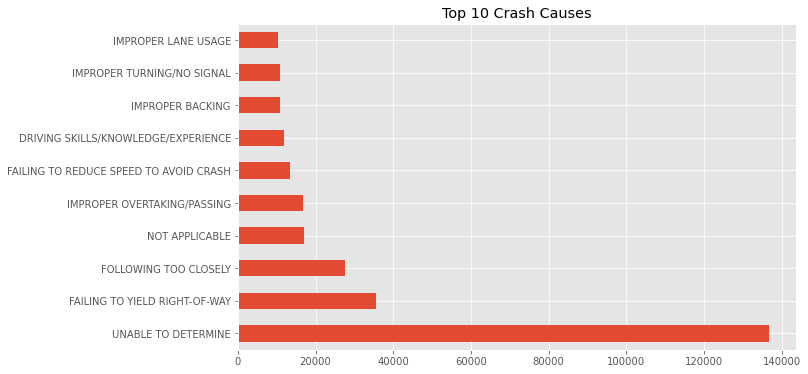

In [6]:
# Target distribution
plt.figure(figsize=(10,6))
df['PRIM_CONTRIBUTORY_CAUSE'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Crash Causes');

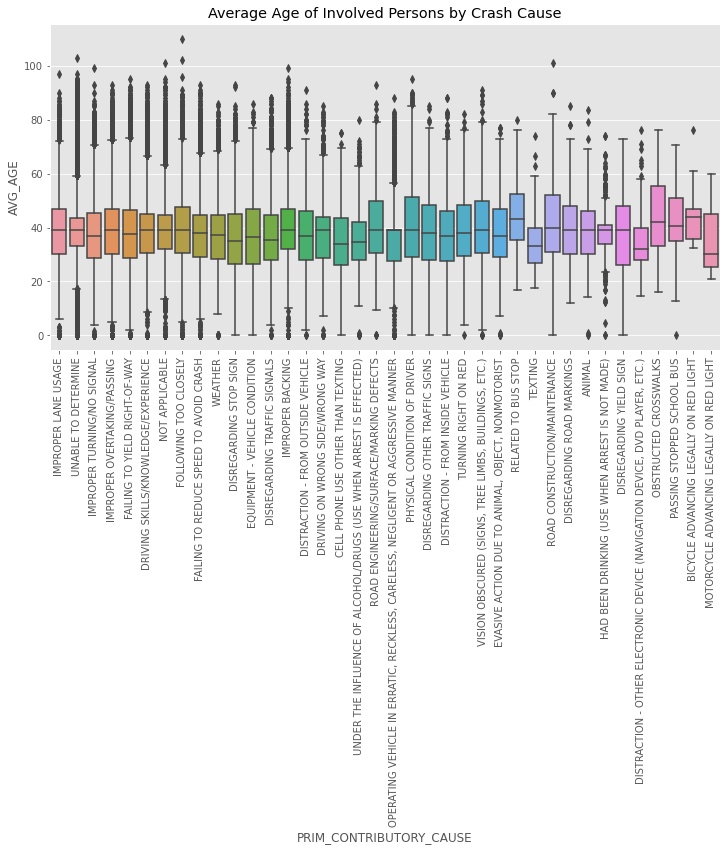

In [7]:
# Visualization with people data
plt.figure(figsize=(12,6))
sns.boxplot(
    x='PRIM_CONTRIBUTORY_CAUSE', 
    y='AVG_AGE', 
    data=enhanced_df[enhanced_df['NUM_PEOPLE'] > 0]
)
plt.title('Average Age of Involved Persons by Crash Cause')
plt.xticks(rotation=90)
plt.show()

## 3. DATA PREPROCESSING

### 3.1 Target Variable Engineering

 - Focused on top 4 crash causes + "OTHER" category
 - Balanced classes for better model performance

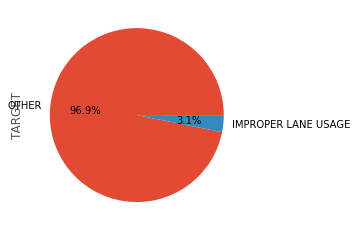

In [5]:
# Bin rare causes
top_causes = ['FAILING TO YIELD', 'DISTRACTION', 'SPEEDING', 'IMPROPER LANE USAGE']
df['TARGET'] = df['PRIM_CONTRIBUTORY_CAUSE'].apply(
    lambda x: x if x in top_causes else 'OTHER'
)

# Verify balance
df['TARGET'].value_counts().plot(kind='pie', autopct='%1.1f%%');

### 3.2 Feature Selection

- Selected features with strongest predictive power
- Created INJURY_CRASH binary feature from injury data

In [8]:
# Create a target variable
enhanced_df['INJURY_CRASH'] = (enhanced_df['MOST_SEVERE_INJURY'] != 'NO INDICATION OF INJURY').astype(int)

# Select features including people-related ones
features = {
    'numeric': ['POSTED_SPEED_LIMIT', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'NUM_PEOPLE', 'NUM_FATALITIES', 'AVG_AGE'],
    'categorical': ['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND'],
    'binary': ['INJURY_CRASH']
}

# Clean data
df_clean = enhanced_df.dropna(subset=features['numeric']).copy()
df_clean[features['categorical']] = df_clean[features['categorical']].fillna('UNKNOWN')


In [9]:
print("Columns in df_clean:", df_clean.columns.tolist())

Columns in df_clean: ['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'NUM_PEOPLE', 'NUM_FATALITIES', 'AVG_AGE', 'INJURY_CRASH']

In [10]:
# create the missing INJURY_CRASH column
df_clean['INJURY_CRASH'] = (df_clean['MOST_SEVERE_INJURY'] != 'NO INDICATION OF INJURY').astype(int)

# Verify the new column
print("\nINJURY_CRASH value counts:")
print(df_clean['INJURY_CRASH'].value_counts())

# Update features dictionary
features = {
    'numeric': ['POSTED_SPEED_LIMIT', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK'],
    'categorical': ['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND'],
    'binary': ['INJURY_CRASH']  # Now this exists
}


INJURY_CRASH value counts:
0    277724
1     49884
Name: INJURY_CRASH, dtype: int64


**Handling Missing Data**:
   - Dropped rows with missing numeric features
   - Filled categorical missing values with 'UNKNOWN'

### 3.3 Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split

X = df_clean[features['numeric'] + features['categorical']]
y = df_clean['INJURY_CRASH']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("\nSuccess! Split completed:")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")


Success! Split completed:
Training samples: 229,325
Test samples: 98,283


## 4. MODELLING

### 4.1 Baseline Model (Logistic Regression)

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), features['numeric']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), features['categorical'])
])

# Model pipeline
baseline = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

baseline.fit(X_train, y_train)
print("Baseline Accuracy:", baseline.score(X_test, y_test))


Baseline Accuracy: 0.39185820538648597


In [16]:
print(preprocessor) # check to see if preprocessor is working

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['POSTED_SPEED_LIMIT', 'CRASH_HOUR',
                                  'CRASH_DAY_OF_WEEK']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['WEATHER_CONDITION',
                                  'ROADWAY_SURFACE_COND'])])


## Feature Importance (Optimized)

Instead of running a full Random Forest on the entire dataset, we:
- Sample only 5,000 training rows
- Limit the depth of trees to reduce compute time

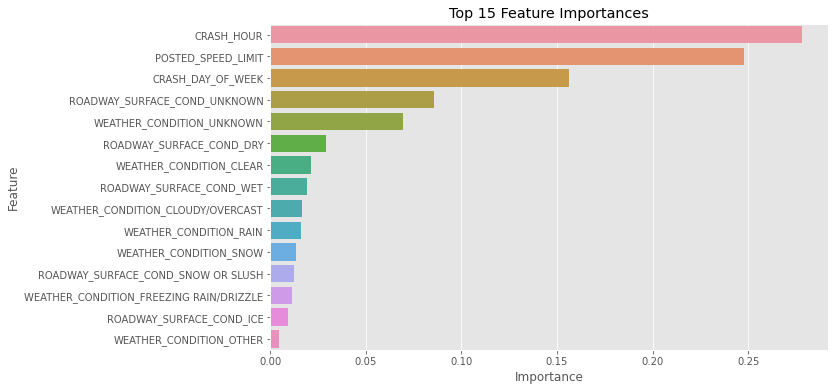

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Sample 5,000 rows from training data
X_small = X_train.sample(n=5000, random_state=42)
y_small = y_train.loc[X_small.index]

# Define Random Forest pipeline with shallow trees
rf_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=50,       # fewer trees
        max_depth=8,           # shallow trees
        class_weight='balanced',
        random_state=42
    ))
])

# Fit the model
rf_pipeline.fit(X_small, y_small)

# Get feature names from encoder
preprocessor.fit(X_small)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(features['categorical'])
all_features = features['numeric'] + list(cat_features)

# Plot top 15 important features
importances = rf_pipeline.named_steps['classifier'].feature_importances_
feature_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(y='Feature', x='Importance', data=feature_df.head(15))
plt.title('Top 15 Feature Importances')
plt.show()


### 4.2 Improved Model (Random Forest)

In [18]:
rf_fast = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=50,  # Fewer trees
        max_depth=10,     # Shallower trees
        class_weight='balanced',   # Handles class imbalance
        random_state=42,    # For reproducibility
        n_jobs=-1        # Uses all CPU cores for faster training
    ))
])

# Train the model 
print("Training Random Forest...")
rf_fast.fit(X_train, y_train)
print("Training completed!")


Training Random Forest...
Training completed!


In [19]:
rf_fast.fit(X_train, y_train)
print("Improved Accuracy:", rf_fast.score(X_test, y_test))

Improved Accuracy: 0.3926925307530295


### 4.3 Model Evaluation

In [20]:
from sklearn.metrics import classification_report

print("Random Forest Performance:")
print(classification_report(y_test, rf_fast.predict(X_test)))


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.91      0.32      0.47     83318
           1       0.18      0.82      0.29     14965

    accuracy                           0.39     98283
   macro avg       0.54      0.57      0.38     98283
weighted avg       0.80      0.39      0.44     98283

